# Backpropagation of Atomic Gradients

We have been working with convolutional neural networks trained on atomic grid representations of protein-ligand complexes. By discretizing chemical structures onto a grid, they can be input to the neural net in a way that naturally takes advantage of the spatial relationships in the data, and also allows us to adapt methods from fields like computer vision that have made great progress with deep learning.

Training large neural networks with many layers is possible because every component of the network is differentiable. The backpropagation algorithm allows us to compute the loss gradient at each layer of the network in succession, by first computing it at the end and then propagating it backwards by repeated application of the chain rule.

$$ \frac{dz}{dx} = \frac{dz}{dy} \frac{dy}{dx} $$

Computing the gradient of the loss with respect to the weights is what allows us to train the network by gradient descent. But having a completely differentiable architecture means that the gradient of any point in the network can be computed with respect to any point before it.

Caffe can backpropagate the gradient to the input layer, in our case the atomic grid. This says how the loss of the network changes as the values in the atom grid change. It would be useful to go one step further and have the gradient with respect to the atom positions themselves- this would allow us to optimize poses. Consider the gradient on a single atom's position using the chain rule:

$$ \frac{dloss}{datom} = \frac{dloss}{dgrid} \frac{dgrid}{datom} $$

Since we are given the grid gradient by Caffe, we are tasked with finding the derivative of the atom grid with respect to a single atom's position. An atom can possibly affect any point on the grid, so this is a summation over grid points.

$$ \frac{dloss}{datom} = \sum_{x,y,z} \frac{dloss}{dgrid_{x,y,z}} \frac{dgrid_{x,y,z}}{datom}$$

An atom can only affect the values of the grid corresponding to that atom type, so we only need to consider a single grid channel. We now have to determine how a single atom's position affects the value at a single gridpoint. The function that computes grid values from atom positions is defined as follows:

\begin{array}{ll}
                           & e^{\frac{-2{dist}^2}{{radius}^2}} & 0 \leq dist \leq radius \\
      grid_{x,y,z}(dist) = & \frac{4}{e^2r^2}{dist}^2 - \frac{12}{e^2r}dist + \frac{9}{e^2} & radius \lt dist \lt 1.5radius \\
                           & 0 & 1.5radius \leq dist \\
\end{array}

And it's derivative:

\begin{array}{ll}
                            & -\frac{4dist}{r^2}e^{\frac{-2{dist}^2}{{radius}^2}} & 0 \leq dist \leq radius \\
      grid'_{x,y,z}(dist) = & \frac{8}{e^2r^2}dist - \frac{12}{e^2r} & radius \lt dist \lt 1.5radius \\
                            & 0 & 1.5radius \leq dist \\
\end{array}

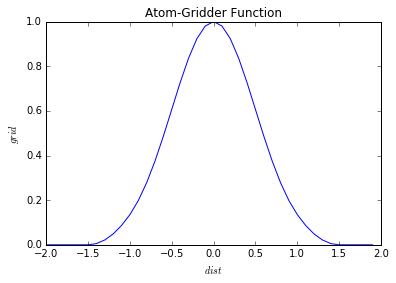

In [26]:
%matplotlib inline
from math import exp
import matplotlib.pyplot as plt

def f(d, r=1):
    if 0 <= d <= r:
        return exp(-2*d**2/r**2)
    elif r < d < 1.5*r:
        return 4/(exp(2)*r**2)*d**2 - 12/(exp(2)*r)*d + 9/exp(2)
    else:
        return 0

d = [0.1 * i for i in range(-20,20)]
r = [f(abs(i)) for i in d]
plt.title('Atom-Gridder Function')
plt.ylabel('$grid$')
plt.xlabel('$dist$')
plt.plot(d, r)
plt.show()

The function is a Gaussian up to the atomic radius, then a quadratic that decays to 0 at 1.5 times the atomic radius. It is defined in terms of the distance between the atom and the gridpoint. In order to get the gradient of the atom grid in terms of atom coordinates, we need one more application of the chain rule, for each coordinate.

$$ \frac{dgrid_{x,y,z}}{datom_x} = \frac{dgrid_{x,y,z}}{ddist} \frac{ddist}{datom_x} $$

$$ \frac{dgrid_{x,y,z}}{datom_y} = \frac{dgrid_{x,y,z}}{ddist} \frac{ddist}{datom_y} $$

$$ \frac{dgrid_{x,y,z}}{datom_z} = \frac{dgrid_{x,y,z}}{ddist} \frac{ddist}{datom_z} $$

The standard Euclidean distance formula is used:

$$ dist = \sqrt{(grid_x - atom_x)^2 + (grid_y - atom_y)^2 + (grid_z - atom_z)^2} $$

Its derivative takes the same form for all three coordinates:

$$ \frac{ddist}{datom_x} = \frac{atom_x-grid_x}{\sqrt{(grid_x - atom_x)^2 + (grid_y - atom_y)^2 + (grid_z - atom_z)^2}} = \frac{atom_x-grid_x}{dist} $$

$$ \frac{ddist}{datom_y} = \frac{atom_x-grid_x}{\sqrt{(grid_y - atom_y)^2 + (grid_y - atom_y)^2 + (grid_z - atom_z)^2}} = \frac{atom_y-grid_y}{dist} $$

$$ \frac{ddist}{datom_y} = \frac{atom_x-grid_x}{\sqrt{(grid_x - atom_x)^2 + (grid_z - atom_z)^2 + (grid_z - atom_z)^2}} = \frac{atom_z-grid_z}{dist} $$

Note that these correspond to component vectors of the distance from the atom to the gridpoint along each dimension.

Taking a step back to revisit the full form we are trying to solve, we have the following equation for each coordinate from two applications of the chain rule:

$$ \frac{dloss}{datom_x} = \sum_{x,y,z} \frac{dloss}{dgrid_{x,y,z}} \frac{dgrid_{x,y,z}}{ddist} \frac{ddist}{datom_x} $$

$$ \frac{dloss}{datom_y} = \sum_{x,y,z} \frac{dloss}{dgrid_{x,y,z}} \frac{dgrid_{x,y,z}}{ddist} \frac{ddist}{datom_y} $$

$$ \frac{dloss}{datom_z} = \sum_{x,y,z} \frac{dloss}{dgrid_{x,y,z}} \frac{dgrid_{x,y,z}}{ddist} \frac{ddist}{datom_z} $$

We are given the first term by Caffe, and have computed the necessary derivative functions for the second and third term. Putting this all together allows us to compute the gradient of the loss function with respect to any atom's position in 3D space.

In [29]:
import py3Dmol
view = py3Dmol.view(query='pdb:1ubq')
view.setStyle({'cartoon':{'color':'spectrum'}})
view